In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score

# Device setup (not required for ExtraTreesClassifier but kept for compatibility)
device = "cpu"

# Label mapping
label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# Data directory and CSV path
csv_path = "/content/drive/MyDrive/xrd_model_training/structure_info.csv"  # Replace with actual path
!unzip /content/drive/MyDrive/xrd_model_training/output_data.zip -d /content/drive/MyDrive/xrd_model_training
data_dir = "/content/drive/MyDrive/xrd_model_training/output_data"  # Directory with .npz files
df = pd.read_csv(csv_path)

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/2010029_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/9005109_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/9001581_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/7204651_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/9015097_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/9017878_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/2002958_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/4336921_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/4344119_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/2106754_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/15

In [ ]:
# Preprocessing function
def load_xrd_data(file_list, data_dir):
    X, y = [], []
    for file_name, label in file_list:
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)

        # Load intensity data
        if os.path.exists(file_path):
            data = np.load(file_path)
            x = data['y_convolved'].astype(np.float32)  # Use intensity data
            X.append(x)
            y.append(label_map[label])
    return np.array(X), np.array(y)

# Split the data into train, test, and validation sets
split_info = {
    "tetragonal": (1000, 1000, 100),
    "orthorhombic": (1000, 1000, 100),
    "trigonal": (1000, 1000, 100),
    "cubic": (1000, 1000, 100),
    "triclinic": (1000, 1000, 100),
    "monoclinic": (1000, 1000, 100),
    "hexagonal": (100, 100, 5)
}

In [ ]:
train_list, test_list, val_list = [], [], []

for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # Split into training, testing, and validation sets
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, _ = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)

In [ ]:
# Load the datasets
X_train, y_train = load_xrd_data(train_list, data_dir)
X_test, y_test = load_xrd_data(test_list, data_dir)
X_val, y_val = load_xrd_data(val_list, data_dir)

# Flatten the feature vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)


In [ ]:
# Train the ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=500,
                            max_depth=30,
                            max_features=7,
                            n_jobs=-1,
                            random_state=42,
                            warm_start=False)

clf.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=30, max_features=7, n_estimators=500, n_jobs=-1,
                     random_state=42)

In [ ]:
# Validate the model
y_val_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Test the model
y_test_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Validation Accuracy: 0.32066115702479336
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.16      0.19       100
           1       0.28      0.18      0.22       100
           2       0.15      0.11      0.13       100
           3       0.35      0.75      0.48       100
           4       0.42      0.55      0.47       100
           5       0.33      0.19      0.24       100
           6       0.00      0.00      0.00         5

    accuracy                           0.32       605
   macro avg       0.25      0.28      0.25       605
weighted avg       0.29      0.32      0.29       605



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.32098360655737707
Test Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.19      0.22      1000
           1       0.23      0.12      0.15      1000
           2       0.24      0.18      0.21      1000
           3       0.35      0.69      0.46      1000
           4       0.41      0.57      0.47      1000
           5       0.29      0.21      0.24      1000
           6       0.00      0.00      0.00       100

    accuracy                           0.32      6100
   macro avg       0.25      0.28      0.25      6100
weighted avg       0.29      0.32      0.29      6100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x800 with 0 Axes>

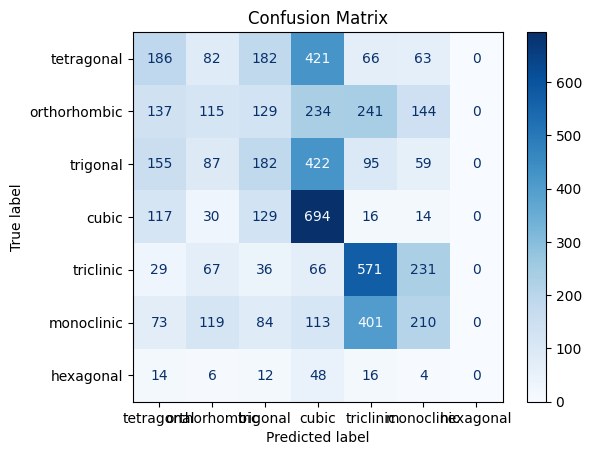

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred, normalize='true')

# Create a display for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths

# Label map for the classification task
label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# Function to extract features from XRD data
def extract_features_with_all_peaks(intensity, angles, max_peaks=10):
    # Find all peaks
    peaks, _ = find_peaks(intensity, height=0.05 * np.max(intensity))  # Adjust height threshold
    peak_positions = angles[peaks]  # Positions of detected peaks (2θ values)
    peak_intensities = intensity[peaks]  # Intensities of detected peaks

    # Total number of detected peaks
    num_detected_peaks = len(peaks)

    # If fewer peaks are detected than the maximum allowed, pad with zeros
    if num_detected_peaks < max_peaks:
        peak_positions = np.pad(peak_positions, (0, max_peaks - num_detected_peaks), mode='constant')
        peak_intensities = np.pad(peak_intensities, (0, max_peaks - num_detected_peaks), mode='constant')
        widths = np.zeros(max_peaks)
    else:
        # Compute Full Width at Half Maximum (FWHM) of each peak
        widths = peak_widths(intensity, peaks)[0]  # widths of the peaks

    # Compute global statistics
    avg_peak_intensity = np.mean(peak_intensities) if num_detected_peaks > 0 else 0
    std_peak_intensity = np.std(peak_intensities) if num_detected_peaks > 0 else 0
    mean_fwhm = np.mean(widths) if num_detected_peaks > 0 else 0
    std_fwhm = np.std(widths) if num_detected_peaks > 0 else 0

    # Create feature vector with peak positions, intensities, and FWHM, followed by global statistics
    feature_vector = np.concatenate([
        peak_positions[:max_peaks],  # First 10 peaks' positions
        peak_intensities[:max_peaks],  # First 10 peaks' intensities
        #widths[:max_peaks],  # First 10 peaks' FWHM values
        #[num_detected_peaks, avg_peak_intensity, std_peak_intensity]
        [num_detected_peaks]
    ])

    return feature_vector

def process_data_with_all_peaks(file_list, data_dir, max_peaks=10):
    features = []
    labels = []
    for file_name, label in file_list:
        # Replace .cif with .npz
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)
        intensity = data['y_convolved'].astype(np.float32)
        angles = data['x_fine'].astype(np.float32)

        # Extract features with all peaks and statistics
        feature = extract_features_with_all_peaks(intensity, angles, max_peaks)
        features.append(feature)
        labels.append(label_map[label])

    return np.array(features), np.array(labels)






In [ ]:
def extract_features_with_sorted_peaks(intensity, angles, max_peaks=10):
    # Find all peaks
    peaks, properties = find_peaks(intensity, height=0.05 * np.max(intensity))  # Adjust height threshold
    peak_positions = angles[peaks]  # Positions of detected peaks (2θ values)
    peak_intensities = intensity[peaks]  # Intensities of detected peaks

    # Sort peaks by intensity in descending order
    sorted_indices = np.argsort(peak_intensities)[::-1]
    sorted_peak_positions = peak_positions[sorted_indices]
    sorted_peak_intensities = peak_intensities[sorted_indices]

    # Total number of detected peaks
    num_detected_peaks = len(peaks)

    # If fewer peaks are detected than the maximum allowed, pad with zeros
    if num_detected_peaks < max_peaks:
        sorted_peak_positions = np.pad(sorted_peak_positions, (0, max_peaks - num_detected_peaks), mode='constant')
        sorted_peak_intensities = np.pad(sorted_peak_intensities, (0, max_peaks - num_detected_peaks), mode='constant')
    else:
        # Limit to the top `max_peaks`
        sorted_peak_positions = sorted_peak_positions[:max_peaks]
        sorted_peak_intensities = sorted_peak_intensities[:max_peaks]

    # Create feature vector with sorted peak positions and intensities
    feature_vector = np.concatenate([
        sorted_peak_positions,  # Sorted peak positions
        sorted_peak_intensities  # Sorted peak intensities
    ,[num_detected_peaks]])

    return feature_vector


def process_data_with_sorted_peaks(file_list, data_dir, max_peaks=10):
    features = []
    labels = []
    for file_name, label in file_list:
        # Replace .cif with .npz
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)
        intensity = data['y_convolved'].astype(np.float32)
        angles = data['x_fine'].astype(np.float32)

        # Extract features with sorted peaks
        feature = extract_features_with_sorted_peaks(intensity, angles, max_peaks)
        features.append(feature)
        labels.append(label_map[label])

    return np.array(features), np.array(labels)


In [ ]:
def extract_features_with_top_peaks(intensity, angles, max_peaks=10):
    # Find all peaks
    peaks, _ = find_peaks(intensity, height=0.05 * np.max(intensity))  # Adjust height threshold
    peak_positions = angles[peaks]  # Positions of detected peaks (2θ values)
    peak_intensities = intensity[peaks]  # Intensities of detected peaks

    # Sort peaks by intensity in descending order
    sorted_indices = np.argsort(peak_intensities)[::-1]
    sorted_peak_positions = peak_positions[sorted_indices]
    sorted_peak_intensities = peak_intensities[sorted_indices]

    # Total number of detected peaks
    num_detected_peaks = len(peaks)

    # If fewer peaks are detected than the maximum allowed, pad with zeros
    if num_detected_peaks < max_peaks:
        sorted_peak_positions = np.pad(sorted_peak_positions, (0, max_peaks - num_detected_peaks), mode='constant')
        sorted_peak_intensities = np.pad(sorted_peak_intensities, (0, max_peaks - num_detected_peaks), mode='constant')
    else:
        # Limit to the top `max_peaks`
        sorted_peak_positions = sorted_peak_positions[:max_peaks]
        sorted_peak_intensities = sorted_peak_intensities[:max_peaks]

    # Create feature vector with top peak positions and intensities
    feature_vector = np.concatenate([
        sorted_peak_positions,  # Top `max_peaks` sorted peak positions
        sorted_peak_intensities  # Top `max_peaks` sorted peak intensities
    ])

    return feature_vector

def process_data_with_top_peaks(file_list, data_dir, max_peaks=10):
    features = []
    labels = []
    for file_name, label in file_list:
        # Replace .cif with .npz
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)
        intensity = data['y_convolved'].astype(np.float32)
        angles = data['x_fine'].astype(np.float32)

        # Extract features with top peaks
        feature = extract_features_with_top_peaks(intensity, angles, max_peaks)
        features.append(feature)
        labels.append(label_map[label])

    return np.array(features), np.array(labels)


In [ ]:
# Split data based on split_info
split_info = {
    "tetragonal": (3000, 500, 100),
    "orthorhombic": (3500, 500, 300),
    "trigonal": (2000, 500, 100),
    "cubic": (2000, 500, 100),
    "triclinic": (1800, 500, 10),
    "monoclinic": (3200, 500, 300),
    "hexagonal": (100, 10, 5)
}

train_list, test_list, val_list = [], [], []
for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # Split the dataset
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, temp_files = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)




In [ ]:
# Define maximum number of peaks for padding
max_peaks = 10

# Process datasets to extract features and labels
X_train, y_train = process_data_with_all_peaks(train_list, data_dir, max_peaks)
X_test, y_test = process_data_with_all_peaks(test_list, data_dir, max_peaks)
X_val, y_val = process_data_with_all_peaks(val_list, data_dir, max_peaks)



In [ ]:
print(X_train[0])

[17.36145401 23.96223068 24.65231133 27.63266182 29.74291039 33.10330582
 35.14354706 38.30391693 41.71432114 42.98447037  0.05396441  1.03090763
  0.68766594  0.05283605  0.26896563  0.39668053  0.68429852  0.05672311
  0.21172881  0.58514643 31.        ]


In [ ]:
# Train the ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=50,
                            max_depth=30,
                            max_features='sqrt',
                            n_jobs=-1,
                            random_state=42,
                            warm_start=False)
clf.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=30, n_estimators=50, n_jobs=-1, random_state=42)

In [ ]:
import os
import pickle

model_file = "extra_trees_model.pkl"
with open(model_file, "wb") as f:
    pickle.dump(clf, f)

# Get the file size
file_size = os.path.getsize(model_file)
print(f"Model file size: {file_size / (1024 * 1024):.2f} MB")

Model file size: 90.06 MB


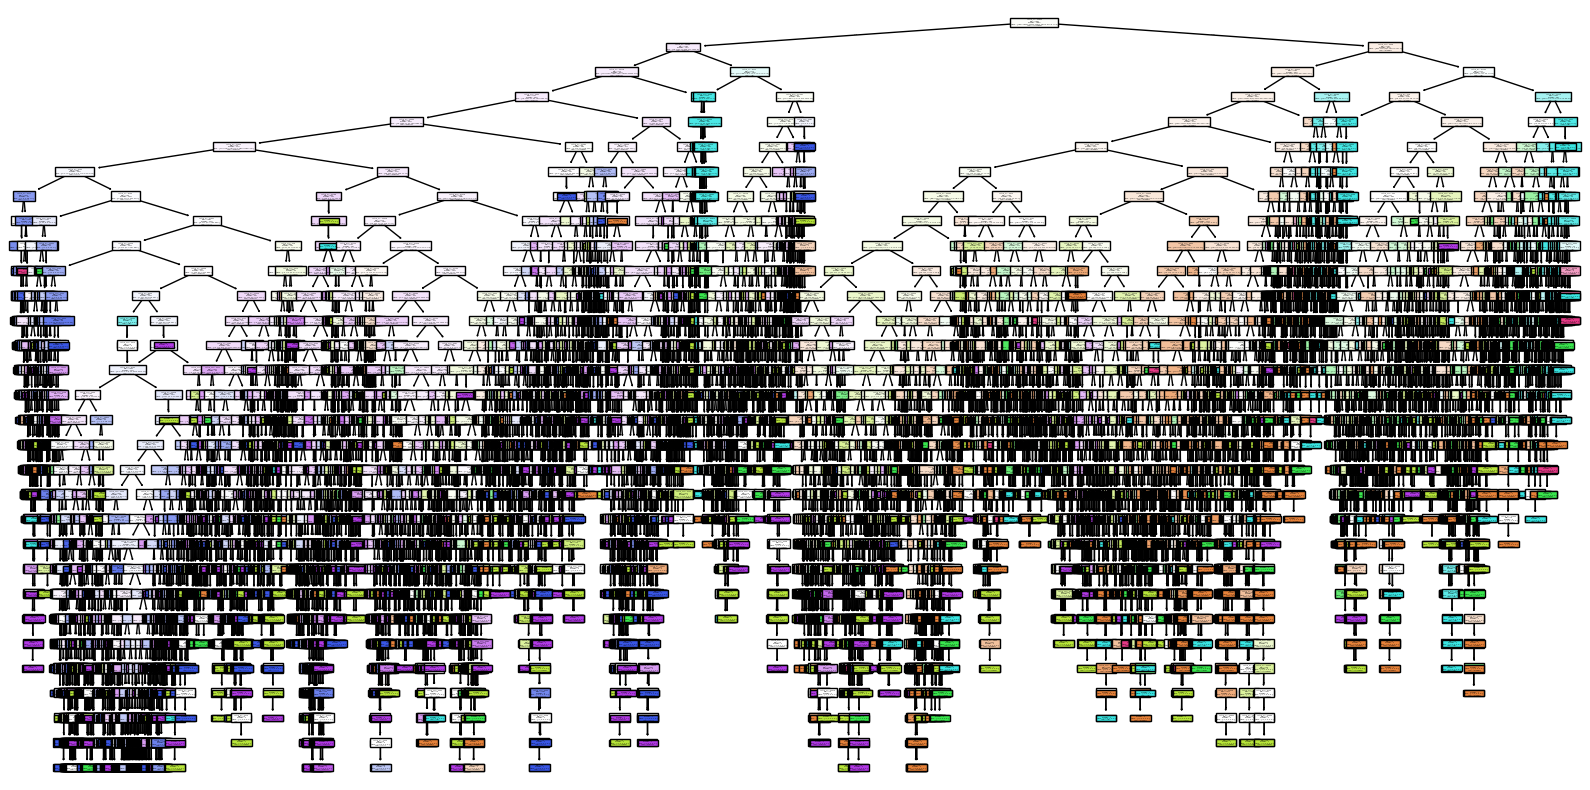

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
tree = clf.estimators_[0]  # Extract the first tree from the ensemble

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=[f"feature_{i}" for i in range(X_train.shape[1])],
    class_names=list(label_map.keys()),  # Names for the 7 classes
    filled=True
)
plt.show()


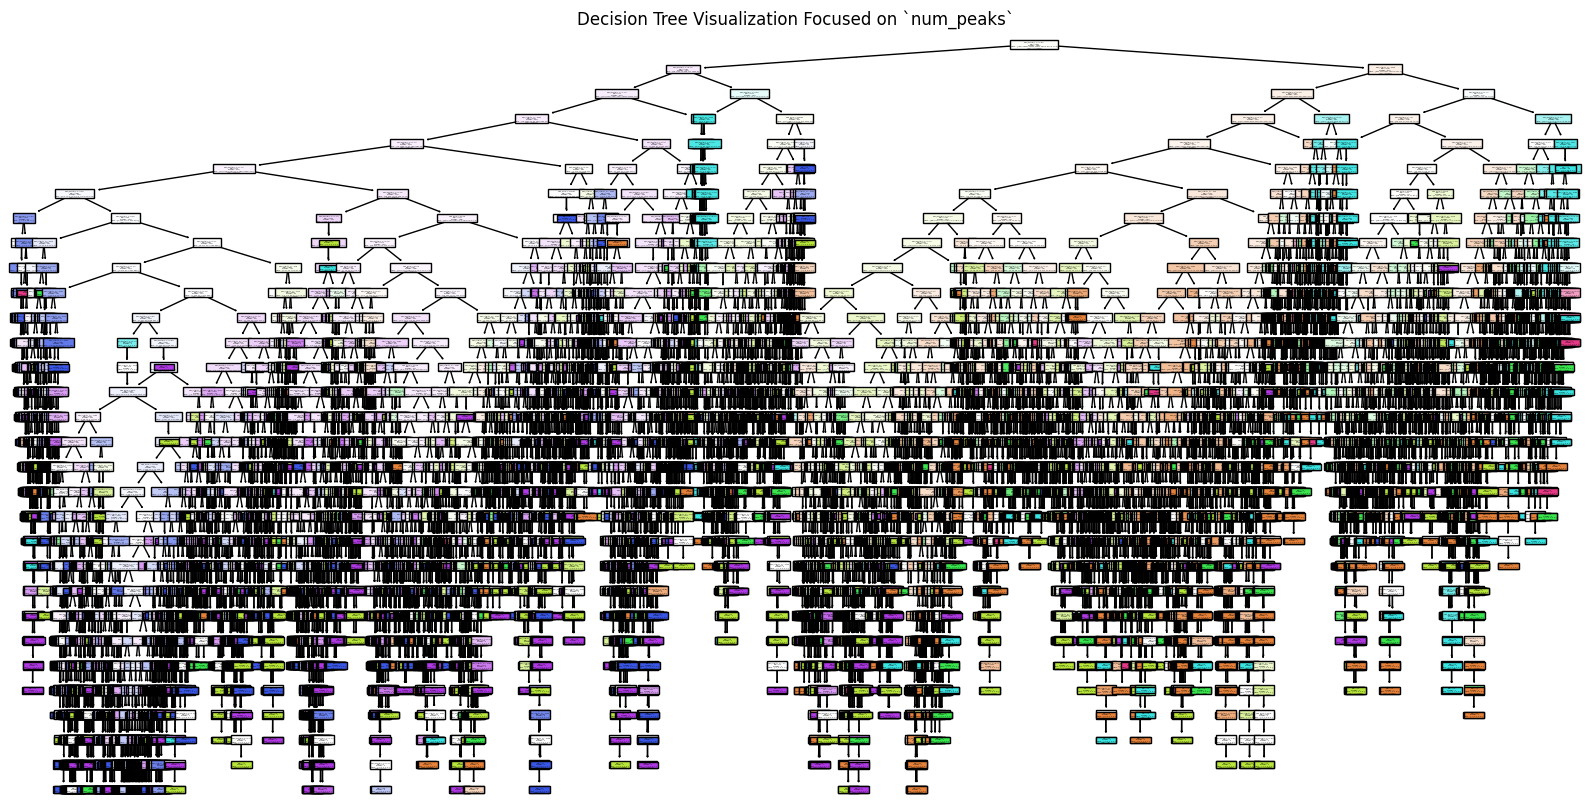

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming `num_peaks` is the last feature in your dataset
max_peaks = 10  # Use the same value as in your feature extraction
feature_names = [f"peak_position_{i}" for i in range(max_peaks)] + \
                [f"peak_intensity_{i}" for i in range(max_peaks)] + \
                ["num_peaks"]


# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=list(label_map.keys()),  # Replace with actual class names
    filled=True
)
plt.title("Decision Tree Visualization Focused on `num_peaks`")
plt.show()


In [ ]:
from sklearn.tree import _tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

def extract_subtree_using_feature(tree, feature_names, focus_feature="num_peaks"):
    """
    Extracts the subtree where the specified feature is used for splitting.

    Parameters:
    - tree: The decision tree object.
    - feature_names: List of feature names.
    - focus_feature: The feature to focus on for extracting the subtree.

    Returns:
    - A new decision tree classifier containing only the relevant subtree.
    """
    # Find the index of the feature we are interested in
    focus_feature_index = feature_names.index(focus_feature)

    # Create a new tree structure with the same parameters
    subtree = DecisionTreeClassifier(max_depth=3, random_state=42)

    # Get the tree structure
    tree_ = tree.tree_

    # Traverse the tree and find nodes where the focus feature is used
    # This will be a list of all nodes that split on the `focus_feature`
    relevant_nodes = []

    def traverse_tree(node):
        if node == _tree.TREE_UNDEFINED:
            return
        # If the node splits on the `focus_feature`, record it
        if tree_.feature[node] == focus_feature_index:
            relevant_nodes.append(node)
        traverse_tree(tree_.children_left[node])  # Go left
        traverse_tree(tree_.children_right[node])  # Go right

    # Start traversing from the root node
    traverse_tree(0)

    # Now, we'll extract the subtree from the relevant nodes
    # Create a list of indices for the relevant subtree nodes
    relevant_tree_indices = relevant_nodes

    # Visualize the subtree (optional)
    plt.figure(figsize=(20, 10))
    plot_tree(
        tree,
        feature_names=feature_names,
        class_names=[str(i) for i in range(len(feature_names))],  # Numeric class labels
        filled=True,
        fontsize=12,
        rounded=True,
        max_depth=3  # Limit the depth of the tree
    )

    return relevant_tree_indices

# Example usage:
max_peaks = 10
feature_names = [f"peak_position_{i}" for i in range(max_peaks)] + \
                [f"peak_intensity_{i}" for i in range(max_peaks)] + \
                ["num_peaks"]

# Get the first tree from the ExtraTreesClassifier model
tree = clf.estimators_[0]

# Extract and visualize the subtree where 'num_peaks' is used for splitting
relevant_subtree = extract_subtree_using_feature(tree, feature_names, focus_feature="num_peaks")


RecursionError: maximum recursion depth exceeded in comparison

Test Accuracy: 0.6733


<Figure size 800x800 with 0 Axes>

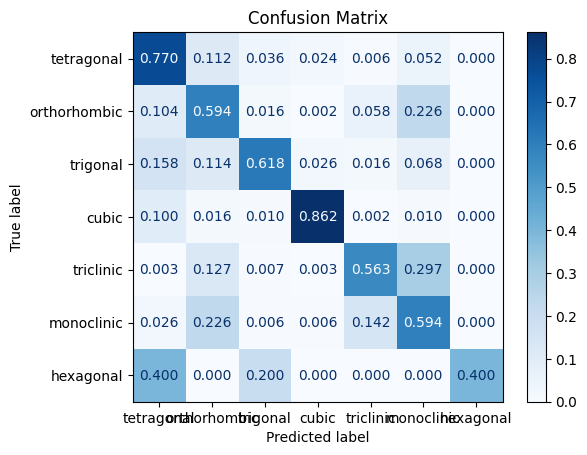

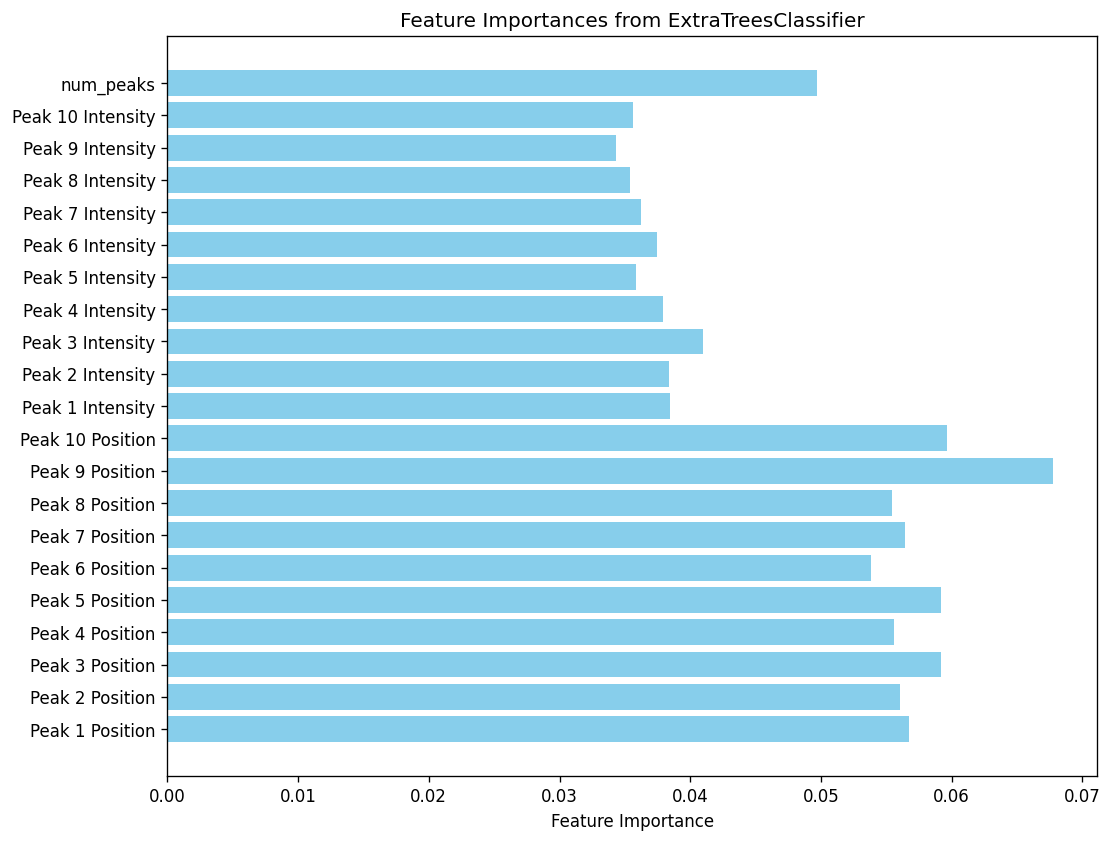

In [ ]:
# Evaluate the model
y_test_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='.3f')
plt.title("Confusion Matrix")
plt.show()

feature_names = [f"Peak {i+1} Position" for i in range(max_peaks)] + \
                [f"Peak {i+1} Intensity" for i in range(max_peaks)] + \
                ["num_peaks"]
                #["num_peaks", "avg_peak_intensity", "std_peak_intensity"]


importances = clf.feature_importances_

# Ensure that the number of features matches the number of feature names
assert len(importances) == len(feature_names), "Mismatch between the number of features and feature names"
plt.figure(figsize=(10, 8), dpi=120)
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importances from ExtraTreesClassifier")
plt.show()

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_and_plot_confusion_matrix_seaborn(model, X_test, y_test, label_map):
    """
    Evaluates the sklearn model on the test data and plots a confusion matrix using seaborn.

    Parameters:
    - model: Trained sklearn model (e.g., ExtraTreesClassifier).
    - X_test: Test features.
    - y_test: True labels for the test data.
    - label_map: A dictionary mapping class names to indices.

    Returns:
    - confusion_matrix_percent: Confusion matrix with percentage accuracies.
    """
    # Predict the labels
    y_pred = model.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    num_classes = len(label_map)

    # Convert confusion matrix to percentage accuracies
    cm_percent = np.zeros_like(cm, dtype=np.float32)
    for i in range(num_classes):
        total = cm[i].sum()
        if total > 0:
            cm_percent[i] = 100 * cm[i] / total

    # Plot confusion matrix with seaborn
    class_names = list(label_map.keys())
    plt.figure(figsize=(10, 8), dpi=120)  # Larger figure size
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title("Confusion Matrix (Percentage Accuracy)", fontsize=16)
    plt.xlabel("Predicted Class", fontsize=14)
    plt.ylabel("True Class", fontsize=14)
    plt.show()

    return cm_percent


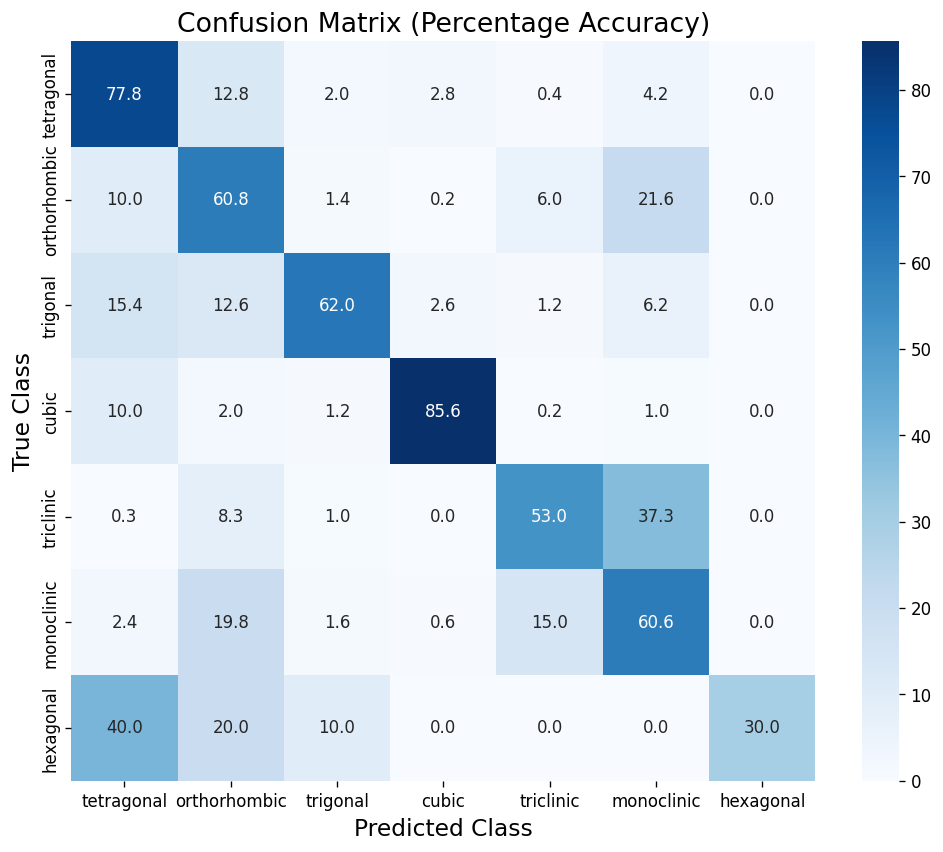

In [ ]:
# Evaluate the ExtraTreesClassifier and plot confusion matrix
confusion_matrix_percent = evaluate_and_plot_confusion_matrix_seaborn(clf, X_test, y_test, label_map)


In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def plot_peaks(intensity, angles, title="XRD Pattern with Peaks"):
    # Find peaks
    peaks, _ = find_peaks(intensity, height=0.1 * np.max(intensity))  # Adjust height threshold

    # Plot XRD pattern
    plt.figure(figsize=(10, 6))
    plt.plot(angles, intensity, label="XRD Pattern")

    # Highlight peaks
    plt.scatter(angles[peaks], intensity[peaks], color='red', label="Detected Peaks", zorder=3)
    plt.xlabel("Angle (2θ)")
    plt.ylabel("Intensity")
    plt.title(title)
    plt.legend()
    plt.show()


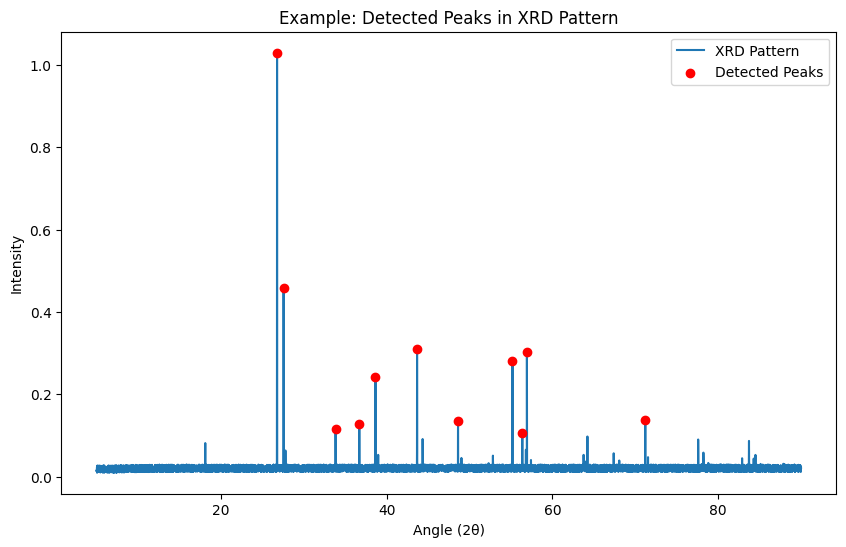

In [ ]:
# Example: Plot the first sample from the training set
example_file, _ = train_list[0]
example_file = example_file.replace('.cif', '_convolved.npz')
example_path = os.path.join(data_dir, example_file)

# Load the data
example_data = np.load(example_path)
example_intensity = example_data['y_convolved']
example_angles = example_data['x_fine']

# Plot the peaks
plot_peaks(example_intensity, example_angles, title="Example: Detected Peaks in XRD Pattern")


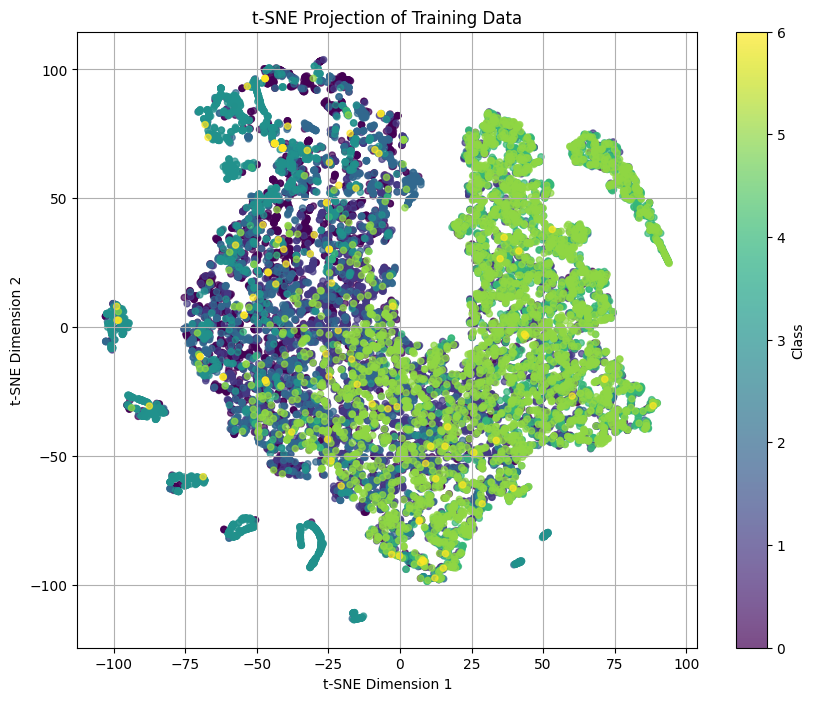

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE to the training set
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train)

# Plot the t-SNE projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', s=20, alpha=0.7
)
plt.colorbar(scatter, label='Class')
plt.title("t-SNE Projection of Training Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


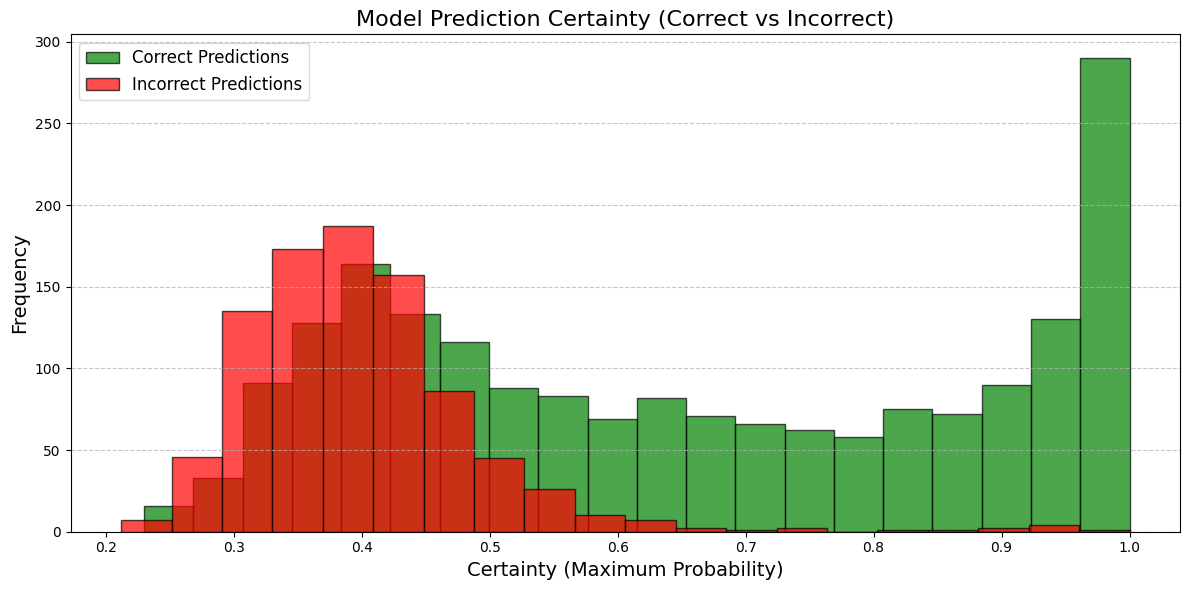

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_certainty_with_correctness(model, X_test, y_test):
    """
    Plots the model's certainty with different colors for correct and incorrect predictions.

    Parameters:
    - model: The trained classifier model (should support predict_proba and predict).
    - X_test: Test data.
    - y_test: True labels for the test data.
    """
    # Get prediction probabilities and predicted classes
    probabilities = model.predict_proba(X_test)
    predicted_classes = model.predict(X_test)

    # Calculate certainty as the maximum probability for each sample
    certainty = np.max(probabilities, axis=1)

    # Determine correctness of predictions
    correctness = predicted_classes == y_test

    # Separate certainty values into correct and incorrect
    correct_certainty = certainty[correctness]
    incorrect_certainty = certainty[~correctness]

    # Plot the certainties
    plt.figure(figsize=(12, 6))
    plt.hist(correct_certainty, bins=20, color='green', alpha=0.7, label='Correct Predictions', edgecolor='black')
    plt.hist(incorrect_certainty, bins=20, color='red', alpha=0.7, label='Incorrect Predictions', edgecolor='black')

    # Add labels and legend
    plt.title("Model Prediction Certainty (Correct vs Incorrect)", fontsize=16)
    plt.xlabel("Certainty (Maximum Probability)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_certainty_with_correctness(clf, X_test, y_test)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix_with_certainty_threshold(model, X_test, y_test, label_map, certainty_threshold=0.7):
    """
    Plots a confusion matrix for predictions with certainty above a given threshold.

    Parameters:
    - model: Trained classifier model (must support predict_proba).
    - X_test: Test data.
    - y_test: True labels for the test data.
    - label_map: Dictionary mapping class names to indices.
    - certainty_threshold: Certainty threshold (default=0.7).
    """
    # Get prediction probabilities and predicted classes
    probabilities = model.predict_proba(X_test)
    predicted_classes = model.predict(X_test)

    # Calculate certainty as the maximum probability for each sample
    certainty = np.max(probabilities, axis=1)

    # Filter samples based on the certainty threshold
    high_certainty_mask = certainty >= certainty_threshold
    filtered_y_test = y_test[high_certainty_mask]
    filtered_predictions = predicted_classes[high_certainty_mask]

    # Generate confusion matrix
    cm = confusion_matrix(filtered_y_test, filtered_predictions, labels=range(len(label_map)), normalize='true')

    # Display confusion matrix
    class_names = list(label_map.keys())
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", ax=ax, colorbar=True)

    plt.title(f"Confusion Matrix (Certainty ≥ {certainty_threshold})", fontsize=16)
    plt.xlabel("Predicted Class", fontsize=14)
    plt.ylabel("True Class", fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

def get_class_identification_percentage(model, X_test, y_test, label_map, certainty_threshold=0.7):
    """
    Calculates the percentage of samples identified for each class above a certainty threshold.

    Parameters:
    - model: Trained classifier model (must support predict_proba).
    - X_test: Test data.
    - y_test: True labels for the test data.
    - label_map: Dictionary mapping class names to indices.
    - certainty_threshold: Certainty threshold (default=0.7).

    Returns:
    - identification_percentage_map: Dictionary mapping each class to the percentage of its samples identified.
    """
    # Get prediction probabilities and predicted classes
    probabilities = model.predict_proba(X_test)
    certainty = np.max(probabilities, axis=1)

    # Filter samples based on the certainty threshold
    high_certainty_mask = certainty >= certainty_threshold
    filtered_y_test = y_test[high_certainty_mask]

    # Count the total and identified samples for each class
    total_samples_per_class = {class_name: 0 for class_name in label_map.keys()}
    identified_samples_per_class = {class_name: 0 for class_name in label_map.keys()}

    for true_label in y_test:
        class_name = list(label_map.keys())[list(label_map.values()).index(true_label)]
        total_samples_per_class[class_name] += 1

    for identified_label in filtered_y_test:
        class_name = list(label_map.keys())[list(label_map.values()).index(identified_label)]
        identified_samples_per_class[class_name] += 1

    # Calculate the percentage of identified samples for each class
    identification_percentage_map = {
        class_name: (identified_samples_per_class[class_name] / total_samples_per_class[class_name] * 100)
        if total_samples_per_class[class_name] > 0 else 0
        for class_name in label_map.keys()
    }

    return identification_percentage_map


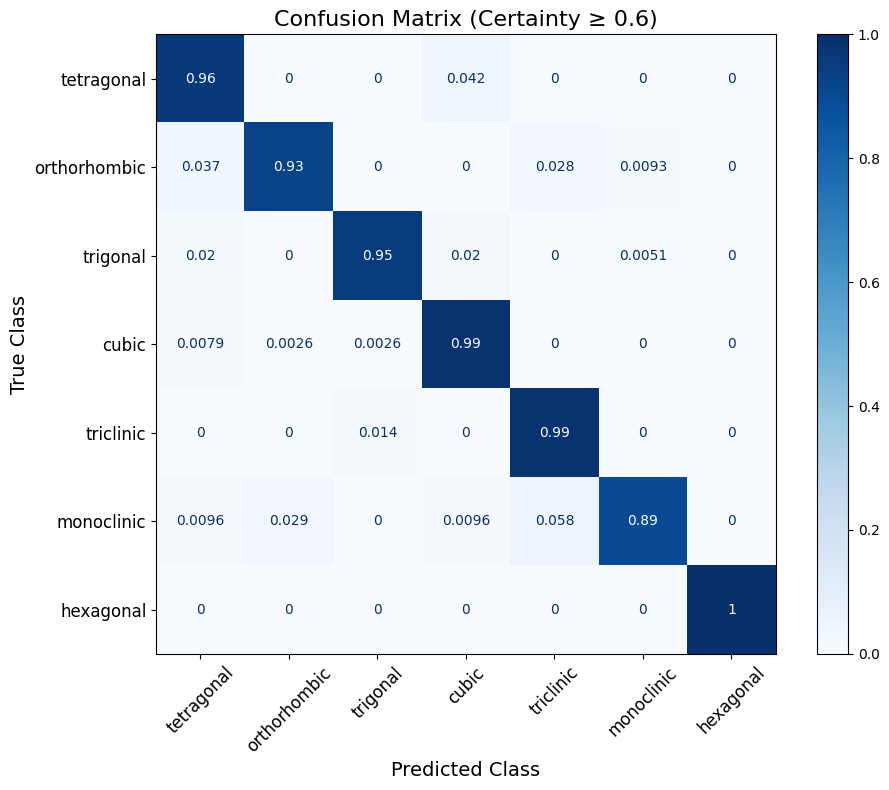

Identification percentages (certainty ≥ 0.6):
tetragonal: 42.80%
orthorhombic: 21.40%
trigonal: 39.40%
cubic: 76.00%
triclinic: 23.00%
monoclinic: 20.80%
hexagonal: 20.00%


In [ ]:
certainty_threshold = 0.6
plot_confusion_matrix_with_certainty_threshold(clf, X_test, y_test, label_map, certainty_threshold)

identification_percentage_map = get_class_identification_percentage(clf, X_test, y_test, label_map, certainty_threshold)
# Print the results
print(f"Identification percentages (certainty ≥ {certainty_threshold}):")
for class_name, percentage in identification_percentage_map.items():
    print(f"{class_name}: {percentage:.2f}%")


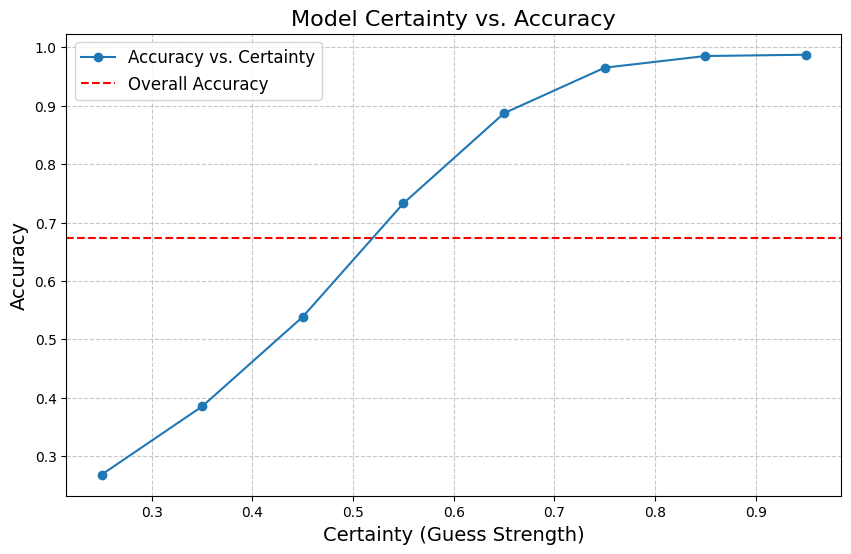

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_certainty_vs_accuracy(model, X_test, y_test, num_bins=10):
    """
    Analyzes the relationship between model certainty and accuracy.

    Parameters:
    - model: Trained classifier model (must support predict_proba).
    - X_test: Test features.
    - y_test: Test labels.
    - num_bins: Number of bins for certainty scores (default=10).

    Returns:
    - None (displays a plot).
    """
    # Predict probabilities and labels
    probabilities = model.predict_proba(X_test)
    certainty = np.max(probabilities, axis=1)  # Highest probability for each prediction
    predictions = np.argmax(probabilities, axis=1)  # Predicted class

    # Initialize bins
    bins = np.linspace(0, 1, num_bins + 1)  # Bin edges
    bin_indices = np.digitize(certainty, bins, right=True)  # Bin assignments
    accuracy_per_bin = []

    # Calculate accuracy for each bin
    for i in range(1, len(bins)):
        indices_in_bin = np.where(bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            correct = (predictions[indices_in_bin] == y_test[indices_in_bin]).sum()
            accuracy = correct / len(indices_in_bin)
        else:
            accuracy = np.nan  # No data in this bin
        accuracy_per_bin.append(accuracy)

    # Plot
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Middle of each bin
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, accuracy_per_bin, marker='o', label="Accuracy vs. Certainty")
    plt.axhline(y=np.mean(predictions == y_test), color='r', linestyle='--', label="Overall Accuracy")
    plt.title("Model Certainty vs. Accuracy", fontsize=16)
    plt.xlabel("Certainty (Guess Strength)", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.show()

# Analyze the original model's certainty vs. accuracy
analyze_certainty_vs_accuracy(clf, X_test, y_test)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


Epoch 1/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2955 - loss: 1.7661 - val_accuracy: 0.4242 - val_loss: 1.3355 - learning_rate: 0.0010
Epoch 2/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4167 - loss: 1.3685 - val_accuracy: 0.4416 - val_loss: 1.2808 - learning_rate: 0.0010
Epoch 3/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4365 - loss: 1.3129 - val_accuracy: 0.4530 - val_loss: 1.2835 - learning_rate: 0.0010
Epoch 4/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4448 - loss: 1.3045 - val_accuracy: 0.4609 - val_loss: 1.2218 - learning_rate: 0.0010
Epoch 5/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4567 - loss: 1.2879 - val_accuracy: 0.4737 - val_loss: 1.2156 - learning_rate: 0.0010
Epoch 6/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4585 - loss: 1.2679 - val_accuracy: 0.4719 - val_loss: 1.2160 - learning_rate: 0.0010
Epoch 7/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4647 - loss: 1.

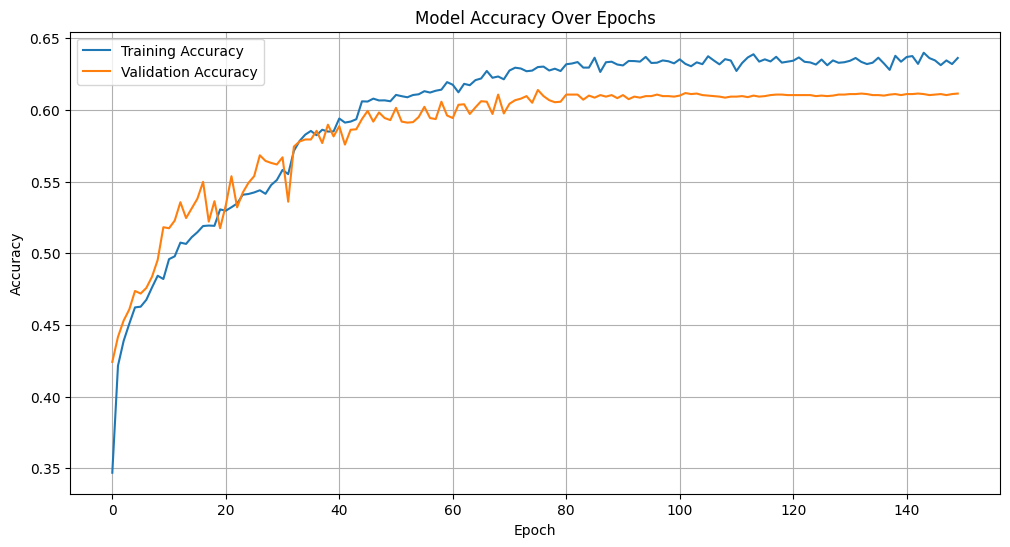

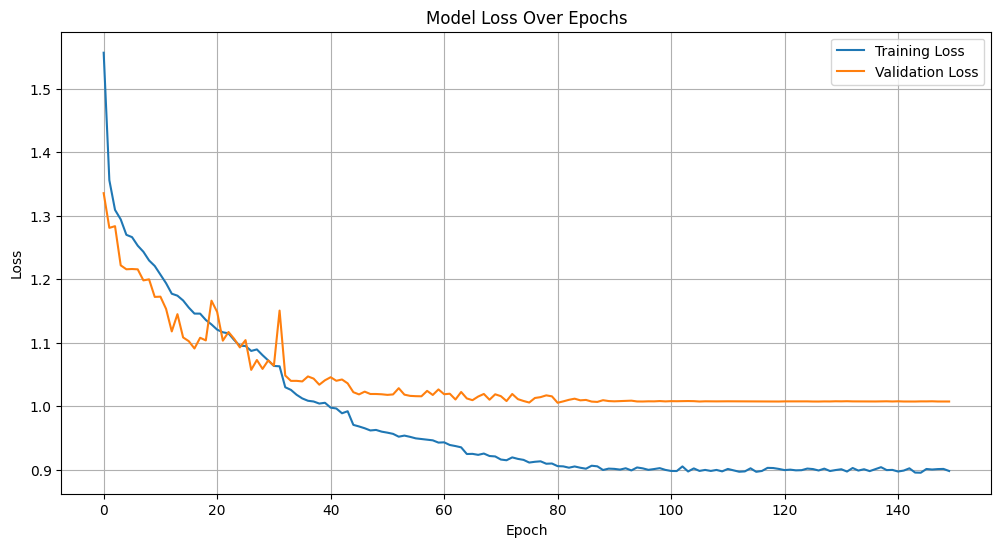

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Reshape data for CNN (CNNs expect 3D input: samples, timesteps, channels)
# Assuming X_train and X_test are 2D arrays (samples, features)
X_train_cnn = np.expand_dims(X_train, axis=-1)  # Add a channel dimension
X_test_cnn = np.expand_dims(X_test, axis=-1)

# Define CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        #Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Model configuration
input_shape = X_train_cnn.shape[1:]  # (features, 1)
num_classes = len(label_map)

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Compile the model with an initial learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callback to reduce learning rate when validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=5,
                              verbose=1,
                              min_lr=1e-6)

# Train the model with the learning rate scheduler callback
history = model.fit(X_train_cnn, y_train,
                    validation_data=(X_test_cnn, y_test),
                    epochs=150, batch_size=32, verbose=1,
                    callbacks=[reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Overall Accuracy: 61.14%


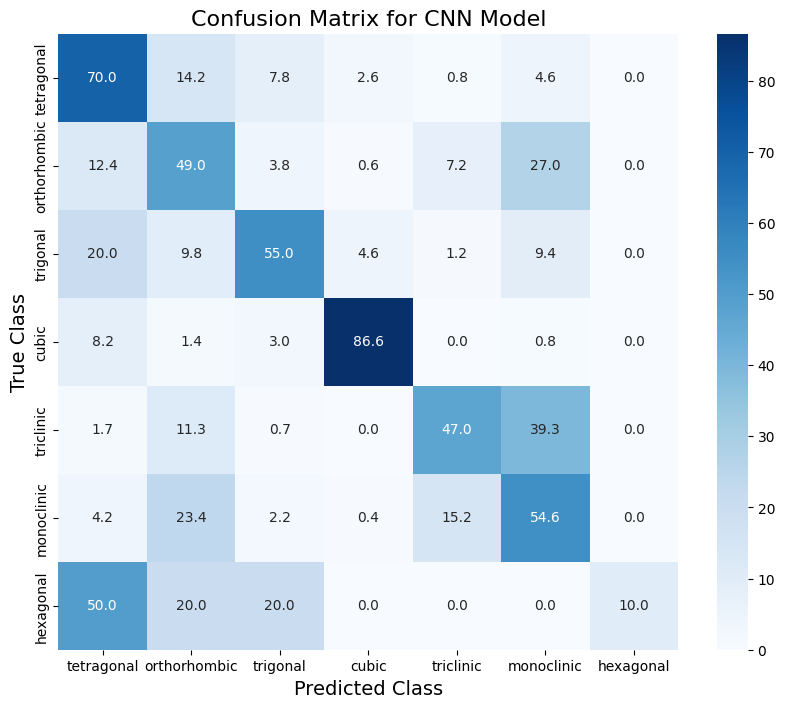

In [ ]:
# Import necessary libraries
from sklearn.metrics import accuracy_score

# Get predictions from the trained model
y_pred_probs = model.predict(X_test_cnn)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get class with highest probability

# Define the confusion matrix plotting function
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, label_map, title="Confusion Matrix"):
    """
    Plots a confusion matrix as a heatmap and prints accuracy.

    Parameters:
    - y_true: Ground truth labels.
    - y_pred: Predicted labels.
    - label_map: A dictionary mapping class names to indices.
    - title: Title for the confusion matrix plot.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # Plot confusion matrix as a heatmap
    class_names = list(label_map.keys())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Class", fontsize=14)
    plt.ylabel("True Class", fontsize=14)
    plt.show()

# Use the function to plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, label_map, title="Confusion Matrix for CNN Model")


Epoch 1/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1975 - loss: 2.5268 - val_accuracy: 0.3267 - val_loss: 1.6341 - learning_rate: 1.0000e-04
Epoch 2/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3161 - loss: 1.6432 - val_accuracy: 0.3477 - val_loss: 1.5116 - learning_rate: 1.0000e-04
Epoch 3/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3449 - loss: 1.5370 - val_accuracy: 0.3769 - val_loss: 1.4006 - learning_rate: 1.0000e-04
Epoch 4/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3926 - loss: 1.4417 - val_accuracy: 0.4423 - val_loss: 1.3351 - learning_rate: 1.0000e-04
Epoch 5/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4046 - loss: 1.4011 - val_accuracy: 0.4477 - val_loss: 1.3254 - learning_rate: 1.0000e-04
Epoch 6/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4208 - loss: 1.3492 - val_accuracy: 0.4484 - val_loss: 1.3111 - learning_rate: 1.0000e-04
Epoch 7/150
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc

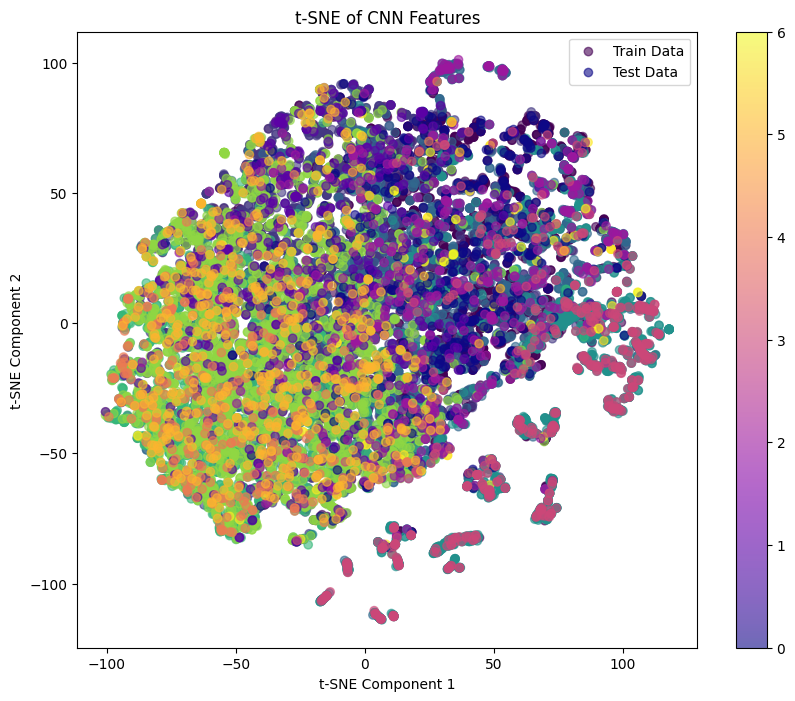

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Assuming X_train_cnn and X_test_cnn are already reshaped and model is trained

# Define CNN model (same as before)
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        #Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Model configuration
input_shape = X_train_cnn.shape[1:]  # (features, 1)
num_classes = len(label_map)

# Create and compile the model
model = create_cnn_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callback to reduce learning rate when validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=5,
                              verbose=1,
                              min_lr=1e-6)

# Train the model with the learning rate scheduler callback
history = model.fit(X_train_cnn, y_train,
                    validation_data=(X_test_cnn, y_test),
                    epochs=150, batch_size=32, verbose=1,
                    callbacks=[reduce_lr])

# Extract features from the trained model (penultimate layer)
feature_extractor = Sequential(model.layers[:-1])  # Remove the final softmax layer
features_train = feature_extractor.predict(X_train_cnn)  # Extract features from training data
features_test = feature_extractor.predict(X_test_cnn)    # Extract features from test data

# Combine train and test features for t-SNE
features_combined = np.vstack((features_train, features_test))

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_combined)

# Create scatter plot for t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:len(features_train), 0], tsne_results[:len(features_train), 1],
            c=y_train, cmap='viridis', label='Train Data', alpha=0.6)
plt.scatter(tsne_results[len(features_train):, 0], tsne_results[len(features_train):, 1],
            c=y_test, cmap='plasma', label='Test Data', alpha=0.6)
plt.colorbar()
plt.title('t-SNE of CNN Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


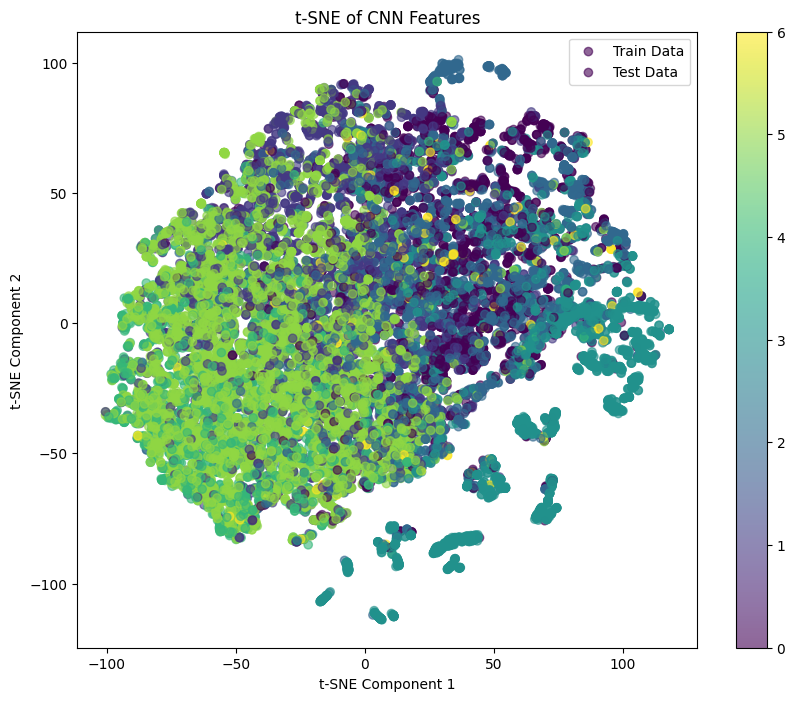

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap (Blue -> Green -> Yellow)
# Create scatter plot for t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:len(features_train), 0], tsne_results[:len(features_train), 1],
            c=y_train, cmap='viridis', label='Train Data', alpha=0.6)
plt.scatter(tsne_results[len(features_train):, 0], tsne_results[len(features_train):, 1],
            c=y_test, cmap='viridis', label='Test Data', alpha=0.6)
plt.colorbar()
plt.title('t-SNE of CNN Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()



88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


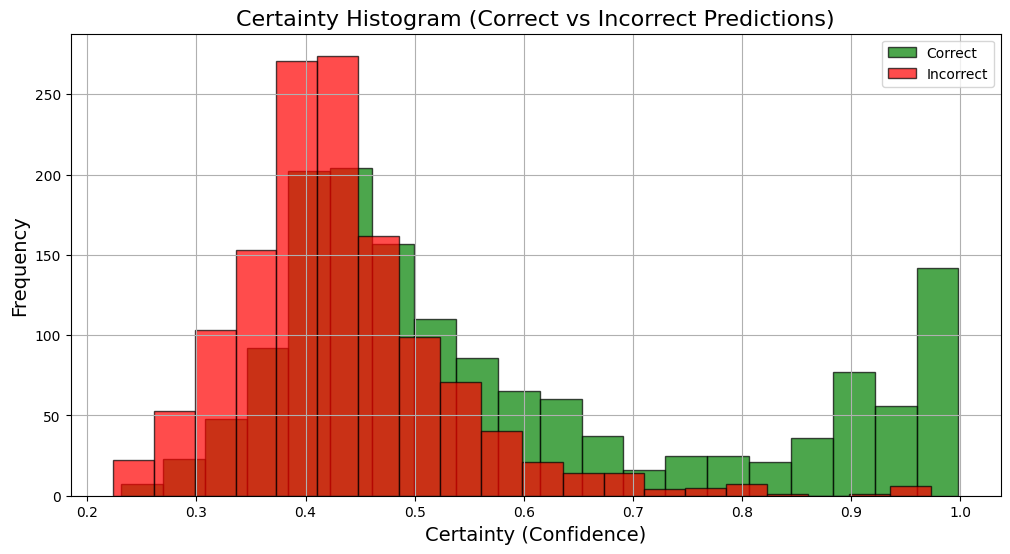

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model, and 'X_test_cnn' and 'y_test' are your test data and labels.

# Get model predictions and the corresponding probabilities
predictions = model.predict(X_test_cnn)  # Shape: (num_samples, num_classes)
predicted_labels = np.argmax(predictions, axis=1)  # Predicted class labels
true_labels = y_test  # True class labels

# Calculate the certainty (confidence) for each prediction (max probability)
certainty = np.max(predictions, axis=1)

# Determine correct and incorrect predictions
correct_predictions = predicted_labels == true_labels
incorrect_predictions = ~correct_predictions

# Plot histogram
plt.figure(figsize=(12, 6))

# Plot histogram for correct predictions (color: green)
plt.hist(certainty[correct_predictions], bins=20, alpha=0.7, color='green', label='Correct', edgecolor='black')

# Plot histogram for incorrect predictions (color: red)
plt.hist(certainty[incorrect_predictions], bins=20, alpha=0.7, color='red', label='Incorrect', edgecolor='black')

# Add labels and title
plt.xlabel('Certainty (Confidence)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Certainty Histogram (Correct vs Incorrect Predictions)', fontsize=16)
plt.legend()

plt.grid(True)
plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


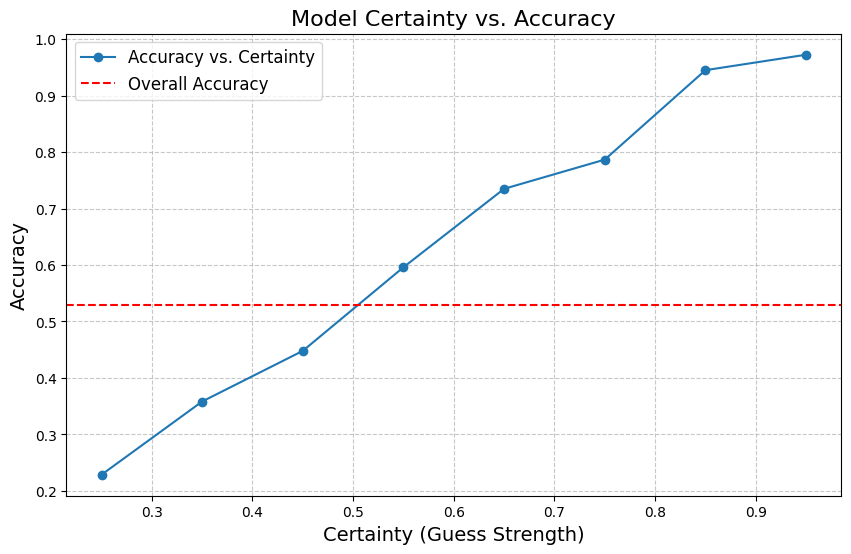

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_certainty_vs_accuracy_cnn(model, X_test, y_test, num_bins=10):
    """
    Analyzes the relationship between CNN model certainty and accuracy.

    Parameters:
    - model: Trained CNN model.
    - X_test: Test features (3D for CNNs).
    - y_test: Test labels.
    - num_bins: Number of bins for certainty scores (default=10).

    Returns:
    - None (displays a plot).
    """
    # Predict probabilities using the CNN model
    probabilities = model.predict(X_test)  # (samples, classes)
    certainty = np.max(probabilities, axis=1)  # Highest probability for each prediction
    predictions = np.argmax(probabilities, axis=1)  # Predicted class

    # Initialize bins
    bins = np.linspace(0, 1, num_bins + 1)  # Bin edges
    bin_indices = np.digitize(certainty, bins, right=True)  # Bin assignments
    accuracy_per_bin = []

    # Calculate accuracy for each bin
    for i in range(1, len(bins)):
        indices_in_bin = np.where(bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            correct = (predictions[indices_in_bin] == y_test[indices_in_bin]).sum()
            accuracy = correct / len(indices_in_bin)
        else:
            accuracy = np.nan  # No data in this bin
        accuracy_per_bin.append(accuracy)

    # Plot
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Middle of each bin
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, accuracy_per_bin, marker='o', label="Accuracy vs. Certainty")
    plt.axhline(y=np.mean(predictions == y_test), color='r', linestyle='--', label="Overall Accuracy")
    plt.title("Model Certainty vs. Accuracy", fontsize=16)
    plt.xlabel("Certainty (Guess Strength)", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.show()

# Example usage for a CNN model
# Assuming you have a trained model 'model' and the test data (X_test, y_test)
analyze_certainty_vs_accuracy_cnn(model, X_test_cnn, y_test)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Ensure X_train and X_test are 2D (samples, features)
# Assuming the peak data is already in this format

# Define the dense model
def create_dense_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Model configuration
input_shape = X_train.shape[1]  # Number of features
num_classes = len(label_map)

# Create and compile the model
model = create_dense_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=150, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Dense Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Dense Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
